
Gaëlle_Genvrin_P5_4_112024

# PLAN

**1. Introduction et Objectifs**

Explication des objectifs du notebook

Rôle des tags dans la classification supervisée

**2. Préparation des données**

<i>2.1. Gestion des Tags</i>

Les tags sont les labels de notre problème de classification.

Chaque question (Title + Body) est associée à un ou plusieurs tags.

<u>Stratégies possibles</u> :

Classification multi-label : chaque question peut appartenir à plusieurs classes (tags).

Classification multi-classe (approximative) : en limitant à un tag dominant.

<i>2.2. Prénettoyage</i>

Fusion des colonnes Title et Body en une seule variable Title_Body

Nettoyage de Tags (on enlève les balises)

Gestion des outliers (questions trop longues, trop courtes…) Non réalisé

Vérification des déséquilibres de classes (certains tags plus fréquents que d'autres) non réalisé

**3. Transformation des données en fonction des modélisations sur 3 colonnes**

transform_bow_fct → Bag-of-Words -> Word2Vec (1° colonne)

transform_bow_lem_fct → Bag-of-Words lemmatisé -> Word2Vec (2° colonne)

transform_dl_fct → Approches Deep Learning -> USE, BERT (3° et 4° colonnes)

Traitement des Tags avec TF_IDF

**4. Expérimentation des modèles supervisés**

<i>4.1. Approche Bag-of-Words</i>

TF-IDF + Modèle de classification supervisée (Logistic Regression, Random Forest, SGD CLassifier)

<i>4.2. Approches Word/Sentence Embedding</i>

Word2Vec (sur BoW Lemmatisé) (RL, RF)

Universal Sentence Encoder (USE) (RL, LightGBM)

BERT (fine-tuning ou embeddings pré-entraînés) (LightGBM, MLP)


**5. Suivi des expérimentations dans MLFlow puis création de l'API**

MLFlow :Tracking des hyperparamètres et résultats, Taux de couverture des tags, Stockage centralisé des modèles
API : utilisation de streamlit

**8. Conclusion et prochaines étapes**

Résumé des résultats

Perspectives d’amélioration

In [1]:
import numpy as np
print("Version :", np.__version__)
print("Chemin :", np.__file__)


Version : 1.26.4
Chemin : C:\envs\env5\lib\site-packages\numpy\__init__.py


In [2]:
!pip freeze
# ai modifié click 7.1.2 en même temps que typer



anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.3.0
babel==2.17.0
beautifulsoup4==4.13.3
bleach==6.2.0
blis==0.7.11
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
click==7.1.2
colorama==0.4.6
comm==0.2.2
confection==0.1.5
contourpy==1.3.0
cycler==0.12.1
cymem==2.0.11
debugpy==1.8.13
decorator==5.2.1
defusedxml==0.7.1
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl#sha256=dfba97b3cb5c177f60c4087a5b4f5c9d7f5c0fce7150d8aa7c0aab4eb4811a07
exceptiongroup==1.2.2
executing==2.2.0
fastjsonschema==2.21.1
fonttools==4.57.0
fqdn==1.5.1
h11==0.14.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
importlib_metadata==8.6.1
importlib_resources==6.5.2
ipykernel==6.29.5
ipython==8.18.1
ipywidgets==8.1.5
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
json5==0.12.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschem

In [2]:

# SELECTION DE BIBLIOTHEQUES pour limiter l'importation de bibliothèques dans les scripts techniques par la suite

# Pour la gestion des données
import pandas as pd
import numpy as np
import os

# Pour le traitement du texte
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, Doc2Vec
import spacy
from sklearn.preprocessing import LabelEncoder

# Pour le deep learning et les embeddings
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_hub as hub
from transformers import BertTokenizer, TFBertModel, BertModel

# Pour la modélisation supervisée
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline

# Pour la gestion du suivi MLFlow
import mlflow
import mlflow.sklearn
import mlflow.keras
from mlflow.models import infer_signature

# Pour les outils de MLOps et industrialisation
import kedro
from kedro.framework.context import KedroContext

# Pour le prétraitement et les transformations de données
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pour l'évaluation et la gestion de l'expérience
import matplotlib.pyplot as plt
import seaborn as sns

# Autres bibliothèques
from sklearn.datasets import load_iris  # Import de la fonction load_iris pour un essai






Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [3]:
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score,  roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


In [4]:
import joblib

In [5]:
#Bibliothèques qui posent problème :
import evidently
from evidently import ColumnMapping
import prometheus_client
import popmon

In [6]:
# essai

# Démarre un run MLflow
with mlflow.start_run():
    # Enregistrer un paramètre, à titre d'exemple
    mlflow.log_metric("accuracy", 0.95)

# Vérification des logs et l'état dans l'interface MLflow UI (je vais dans le bash et je lance mlflow ui)
print("Run enregistré !")


Run enregistré !


In [7]:
print(mlflow.get_tracking_uri())


file:///C:/Users/ggenv/mlruns


## 1. Introduction et Objectifs
Ce projet vise à développer un système supervisé d’attribution automatique de tags à des textes (titre + corps).<br>
L’objectif est de proposer des tags pertinents afin d’organiser et d’indexer le contenu de manière efficace.<br>
Plusieurs approches sont explorées, en commençant par des modèles classiques tels que TF-IDF ou SVD, combinés à des algorithmes de classification comme la régression logistique, la forêt aléatoire et SGD Classifier.<br>
Des techniques plus avancées sont également mises en œuvre, notamment Word2Vec, ainsi que des modèles de Deep Learning comme BERT et USE.<br>
Le suivi des expériences est assuré via MLflow, avec un accent mis sur l’industrialisation du modèle dans une démarche MLOps.


## 2. Préparation des données

**2.1. Gestion des Tags**

Les tags sont les labels de notre problème de classification.

Chaque question (Title + Body) est associée à un ou plusieurs tags.

In [8]:
# Spécifie le chemin du fichier
chemin_fichier = r"C:\Users\ggenv\OneDrive\Documents\MLE\P5\P5_jeu de donnees\QueryResults3.csv"

# Lecture du fichier CSV
df0 = pd.read_csv(chemin_fichier)

# Affichage des premières lignes
df0.tail()

,CreationDate,PostTypeId,Title,Body,Tags,Id,Score,ViewCount,CommentCount,AnswerCount
49995,2024-10-29 14:59:45,1,How to extract data using LeetCode GraphQL query,<p>I just want to know that how to print all t...,<python><json><web-scraping><python-requests><...,79137785,2,269,1,1
49996,2024-10-29 15:11:25,1,Z-index ignored while transitioning using the ...,<p><strong>Note: The example below uses the <a...,<javascript><css><vue.js><z-index><view-transi...,79137836,1,128,0,1
49997,2024-10-29 15:22:44,1,Give the result string provided minimum number...,<p>A good follow up question asked in one of t...,<string><algorithm><data-structures><stack><dy...,79137882,4,268,10,1
49998,2024-10-29 15:36:53,1,How to Exclude Tagless Structs Using ASTMatcher?,<p>I'm currently working with Clang's ASTMatch...,<c><clang><abstract-syntax-tree><libtooling><c...,79137927,2,57,4,2
49999,2024-10-29 16:11:38,1,define cause for Error in Mock When (MUnit),<p>I tried to define Error with typeID and cau...,<mule><mulesoft><mule4><anypoint-studio><munit>,79138054,1,325,3,1


 **On optera pour la classification multi-label : chaque question peut appartenir à plusieurs classes (tags).**

 **2.2. Pré-nettoyage**


In [9]:
# Fusion des colonnes Title et Body
df0['Title_Body'] = df0['Title'] + " " + df0['Body']

# Affichage des premières lignes pour vérifier
df0[['Title', 'Body', 'Title_Body', 'Tags']].head()

,Title,Body,Title_Body,Tags
0,Optimized way to filter and return objects in ...,<p>I have the following Movie class -</p>\n<pr...,Optimized way to filter and return objects in ...,<java><algorithm><oop><data-structures><time-c...
1,LiveData observer is not removed,<p>I am trying to get <code>LiveData</code> up...,LiveData observer is not removed <p>I am tryin...,<android><kotlin><android-livedata><observer-p...
2,MAUI ContentView can't inherit from custom bas...,<p>I have a ContentView called HomePageOrienta...,MAUI ContentView can't inherit from custom bas...,<inheritance><controls><code-generation><maui>...
3,My if statement is not working in React Native,<p>I want to build a search bar that filters a...,My if statement is not working in React Native...,<react-native><if-statement><components><react...
4,jax.lax.select vs jax.numpy.where,"<p>Was taking a look at the <a href=""https://f...",jax.lax.select vs jax.numpy.where <p>Was takin...,<python><numpy><machine-learning><deep-learnin...


In [10]:
df0[['Title_Body', 'Tags']].head()

,Title_Body,Tags
0,Optimized way to filter and return objects in ...,<java><algorithm><oop><data-structures><time-c...
1,LiveData observer is not removed <p>I am tryin...,<android><kotlin><android-livedata><observer-p...
2,MAUI ContentView can't inherit from custom bas...,<inheritance><controls><code-generation><maui>...
3,My if statement is not working in React Native...,<react-native><if-statement><components><react...
4,jax.lax.select vs jax.numpy.where <p>Was takin...,<python><numpy><machine-learning><deep-learnin...


**Nettoyage des Tags**

In [11]:
import re
pd.set_option('display.max_columns', None)

# Fonction pour extraire le contenu des balises HTML
def extraire_tags(tags):
    # Trouve tout ce qui est à l'intérieur des balises et les met dans une liste
    return ' '.join(re.findall(r'<(.*?)>', tags))

# Appliquer la fonction sur la colonne 'Tags'
df0['Tags'] = df0['Tags'].apply(extraire_tags)

# Vérification des premières lignes
df0[['Tags', 'Title_Body']].head()




,Tags,Title_Body
0,java algorithm oop data-structures time-comple...,Optimized way to filter and return objects in ...
1,android kotlin android-livedata observer-patte...,LiveData observer is not removed <p>I am tryin...
2,inheritance controls code-generation maui cont...,MAUI ContentView can't inherit from custom bas...
3,react-native if-statement components react-nat...,My if statement is not working in React Native...
4,python numpy machine-learning deep-learning jax,jax.lax.select vs jax.numpy.where <p>Was takin...


## 3. Transformation des données en fonction des modélisations sur 4 colonnes

BoW_Word2Vec → Bag-of-Words -> Word2Vec (1° colonne)

BoW_Lem_Word2Vec → Bag-of-Words lemmatisé -> Word2Vec (2° colonne)

DL_USE → Approches Deep Learning -> USE (3° colonne)

DL_BERT → Approches Deep Learning -> BERT (4° colonne)

In [12]:

import pickle

# === 1. Tenter de charger les vecteurs déjà calculés ===
path_df4_Bows = r"C:\envs\P5\df4_Bows.pkl"

if os.path.exists(path_df4_Bows):
    print(">>> Chargement de df4_Bows existant...")
    df4_Bows = pd.read_pickle(path_df4_Bows)
    df0['BoW_Word2Vec'] = df4_Bows['BoW_Word2Vec']
    df0['BoW_Lem_Word2Vec'] = df4_Bows['BoW_Lem_Word2Vec']
    print(">>> Colonnes Word2Vec récupérées depuis df4_Bows. Fin du script.")
else:
    print(">>> Aucun fichier df4_Bows trouvé. Exécution du traitement Word2Vec...")

    # Charger spaCy
    nlp = spacy.load("en_core_web_sm")

    # Nettoyage
    def nettoyer(text):
        text = re.sub(r"\d+", "", text)
        return text

    # Lemmatisation
    def lemmatiser(text):
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

    # Appliquer le nettoyage + optionnellement lemmatisation
    def pretraiter_textes(texts, lemmatize=False):
        textes_prepares = []
        for t in texts:
            t = nettoyer(t)
            if lemmatize:
                t = lemmatiser(t)
            textes_prepares.append(t.split())
        return textes_prepares

    # Construire les corpus
    corpus_bow = pretraiter_textes(df0['Title_Body'], lemmatize=False)
    corpus_lem = pretraiter_textes(df0['Title_Body'], lemmatize=True)

    # Entraîner Word2Vec UNE FOIS pour chaque version
    model_bow = Word2Vec(corpus_bow, vector_size=100, window=5, min_count=1, workers=4)
    model_lem = Word2Vec(corpus_lem, vector_size=100, window=5, min_count=1, workers=4)

    # Moyenne des vecteurs Word2Vec pour chaque texte
    def vectoriser_moyenne(corpus, model):
        vecteurs = []
        for tokens in corpus:
            vects = [model.wv[word] for word in tokens if word in model.wv]
            if vects:
                vecteurs.append(sum(vects)/len(vects))  # Moyenne
            else:
                vecteurs.append([0]*model.vector_size)  # Si aucun mot n'est dans le vocabulaire
        return vecteurs

    # Appliquer les vecteurs
    df0['BoW_Word2Vec'] = vectoriser_moyenne(corpus_bow, model_bow)
    df0['BoW_Lem_Word2Vec'] = vectoriser_moyenne(corpus_lem, model_lem)

    # Sauvegarder dans df4_Bows
    df4_Bows = pd.DataFrame()
    df4_Bows['BoW_Word2Vec'] = df0['BoW_Word2Vec']
    df4_Bows['BoW_Lem_Word2Vec'] = df0['BoW_Lem_Word2Vec']

    df4_Bows.to_pickle(path_df4_Bows)
    print(">>> Traitement terminé. df4_Bows sauvegardé.")

>>> Chargement de df4_Bows existant...
>>> Colonnes Word2Vec récupérées depuis df4_Bows. Fin du script.


In [13]:
import torch

print("PyTorch version :", torch.__version__)
print("CUDA dispo :", torch.cuda.is_available())
print("Version CUDA compilée avec PyTorch :", torch.version.cuda)
print("Nom du GPU détecté :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun")


PyTorch version : 2.5.1+cu121
CUDA dispo : True
Version CUDA compilée avec PyTorch : 12.1
Nom du GPU détecté : NVIDIA GeForce RTX 4080 Laptop GPU


In [14]:
import tensorflow as tf
print("Version de TensorFlow :", tf.__version__)
print("GPU(s) détecté(s) :", tf.config.list_physical_devices('GPU'))


Version de TensorFlow : 2.12.0
GPU(s) détecté(s) : []


In [15]:
from torch.utils.cpp_extension import CUDA_HOME
print("CUDA HOME:", CUDA_HOME)

CUDA HOME: None


In [16]:
import sys
print(sys.executable)

C:\envs\env5\Scripts\python.exe


In [17]:
pip show tensorflow


Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\envs\env5\lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [18]:
import tensorflow as tf
from tensorflow.python.framework import ops
print("CUDA Version:", tf.__version__)


CUDA Version: 2.12.0


# Fonction pour transformer avec Universal Sentence Encoder (USE)

In [19]:
# Chemin vers le fichier sauvegardé
path_df4_USE = r"C:\envs\P5\df4_USE.pkl"

# Vérifier si les embeddings ont déjà été calculés
if os.path.exists(path_df4_USE):
    print(">>> Chargement de df4_USE existant...")
    df4_USE = pd.read_pickle(path_df4_USE)
    df0['DL_USE'] = df4_USE['DL_USE']
    print(">>> Embeddings DL_USE chargés depuis le fichier. Aucun recalcul effectué.")

else:
    print(">>> Fichier df4_USE introuvable, calcul des embeddings en cours...")

    # Charger le modèle Universal Sentence Encoder
    use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/")

    # Nettoyage : suppression des chiffres
    def supprimer_chiffres(text):
        return re.sub(r'\d+', '', text)

    df0['Title_Body_clean'] = df0['Title_Body'].apply(supprimer_chiffres)

    # Fonction pour transformer par batch
    def batch_transform(texts, batch_size=10000):
        embeddings = np.zeros((len(texts), 512))  # 512 = taille vecteur USE
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            batch_embeddings = use_model(batch).numpy()
            embeddings[i:i+batch_size] = batch_embeddings
        return embeddings

    # Appliquer le traitement
    df0['DL_USE'] = list(batch_transform(df0['Title_Body_clean'].tolist()))

    # Sauvegarder dans df4_USE
    df4_USE = pd.DataFrame()
    df4_USE['DL_USE'] = df0['DL_USE']
    df4_USE.to_pickle(path_df4_USE)
    print(">>> Embeddings USE calculés et sauvegardés dans df4_USE.")


>>> Chargement de df4_USE existant...
>>> Embeddings DL_USE chargés depuis le fichier. Aucun recalcul effectué.


In [20]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [21]:

# Extraire les embeddings
X_use = np.vstack(df4_USE['DL_USE'].values)

# Entraîner le scaler
scaler_USE = StandardScaler()
X_use_scaled = scaler_USE.fit_transform(X_use)

# Sauvegarder le scaler
joblib.dump(scaler_USE, r"C:\envs\P5\scaler_USE.joblib")



['C:\\envs\\P5\\scaler_USE.joblib']


embed = scaler_USE([text])  # Liste
embed = tf.convert_to_tensor(embed)  # Convertir en Tensor si nécessaire
probs = model.predict(embed)[0]

In [23]:
df0.head(1)

,CreationDate,PostTypeId,Title,Body,Tags,Id,Score,ViewCount,CommentCount,AnswerCount,Title_Body,BoW_Word2Vec,BoW_Lem_Word2Vec,DL_USE
0,2023-01-01 00:07:53,1,Optimized way to filter and return objects in ...,<p>I have the following Movie class -</p>\n<pr...,java algorithm oop data-structures time-comple...,74972603,2,80,3,1,Optimized way to filter and return objects in ...,"[-1.323314, -0.22006938, 0.10019143, 0.167384,...","[-1.1710372, 0.18554085, 1.1741136, 1.5364493,...","[-0.016126222908496857, -0.06459422409534454, ..."


# Fonction pour transformer avec BERT

In [24]:
df5 = pd.read_pickle(r"C:\Users\ggenv\OneDrive\Documents\MLE\P5\df5.pkl") # Cleaned_Title_Body (50000 * 3)
df5.head()

,Id,Title_Body,Cleaned_Title_Body
0,74972603,Optimized way to filter and return objects in ...,optimize way filter return object java follow ...
1,74972777,LiveData observer is not removed\n<p>I am tryi...,livedata observer remove try get livedata upda...
2,74972784,MAUI ContentView can't inherit from custom bas...,maui contentview inherit custom base class con...
3,74972800,My if statement is not working in React Native...,statement work react native want build search ...
4,74972850,jax.lax.select vs jax.numpy.where\n<p>Was taki...,jax lax select vs jax numpy taking look dropou...


In [25]:
df0['Cleaned_Title_Body'] = df5['Cleaned_Title_Body']
df0.head(1)

,CreationDate,PostTypeId,Title,Body,Tags,Id,Score,ViewCount,CommentCount,AnswerCount,Title_Body,BoW_Word2Vec,BoW_Lem_Word2Vec,DL_USE,Cleaned_Title_Body
0,2023-01-01 00:07:53,1,Optimized way to filter and return objects in ...,<p>I have the following Movie class -</p>\n<pr...,java algorithm oop data-structures time-comple...,74972603,2,80,3,1,Optimized way to filter and return objects in ...,"[-1.323314, -0.22006938, 0.10019143, 0.167384,...","[-1.1710372, 0.18554085, 1.1741136, 1.5364493,...","[-0.016126222908496857, -0.06459422409534454, ...",optimize way filter return object java follow ...


import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [26]:
import pickle
import gc
from tqdm import tqdm

# Configurer l'appareil (GPU si dispo)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Appareil utilisé : {device}")

# Charger le tokenizer et le modèle BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
bert_model.eval()

# Texte à transformer (nécessaire même si on ne régénère pas les embeddings)
texts = df0['Cleaned_Title_Body'].tolist()

# Fonction pour transformer les textes en embeddings BERT
@torch.no_grad()
def batch_transform_bert_torch(texts, batch_size=8):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Vectorisation BERT"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        outputs = bert_model(**inputs)
        batch_embeddings = outputs.pooler_output.cpu().numpy()
        embeddings.extend(batch_embeddings)

        # Libération mémoire
        del inputs, outputs
        torch.cuda.empty_cache()
        gc.collect()

    return embeddings

# Sauvegarde des embeddings dans un fichier pickle
def save_embeddings(embeddings, filename='bert_embeddings.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(embeddings, f)

# Chargement ou création des embeddings
try:
    with open('bert_embeddings.pkl', 'rb') as f:
        embeddings = pickle.load(f)
    print("Embeddings chargés depuis le fichier pickle.")
except FileNotFoundError:
    print("Fichier pickle introuvable. Génération des embeddings BERT...")
    embeddings = batch_transform_bert_torch(texts, batch_size=8)
    save_embeddings(embeddings, 'bert_embeddings.pkl')
    print("Embeddings générés et sauvegardés dans 'bert_embeddings.pkl'.")

# Ajout des embeddings au DataFrame
df0['DL_BERT'] = embeddings
print("Embeddings ajoutés à df0['DL_BERT']")


Appareil utilisé : cuda


[05/10/25 10:11:41] WARNING  C:\envs\env5\lib\site-packages\huggingface_hub\file_download.py:896:   warnings.py:109
                             FutureWarning: `resume_download` is deprecated and will be removed in                 
                             version 1.0.0. Downloads always resume when possible. If you want to                  
                             force a new download, use `force_download=True`.                                      
                               warnings.warn(                                                                      
                                                                                                                   

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embeddings chargés depuis le fichier pickle.
Embeddings ajoutés à df0['DL_BERT']


In [27]:
df0.head(1)


,CreationDate,PostTypeId,Title,Body,Tags,Id,Score,ViewCount,CommentCount,AnswerCount,Title_Body,BoW_Word2Vec,BoW_Lem_Word2Vec,DL_USE,Cleaned_Title_Body,DL_BERT
0,2023-01-01 00:07:53,1,Optimized way to filter and return objects in ...,<p>I have the following Movie class -</p>\n<pr...,java algorithm oop data-structures time-comple...,74972603,2,80,3,1,Optimized way to filter and return objects in ...,"[-1.323314, -0.22006938, 0.10019143, 0.167384,...","[-1.1710372, 0.18554085, 1.1741136, 1.5364493,...","[-0.016126222908496857, -0.06459422409534454, ...",optimize way filter return object java follow ...,"[0.036436696, 0.024416301, -0.97473025, -0.132..."


In [26]:
df0['DL_BERT'].apply(len).value_counts()



DL_BERT
768    50000
Name: count, dtype: int64

**Traitement des Tags**

In [27]:

# Fonction pour compter les mots dans chaque cellule de la colonne 'Tags'
df0['tags_count'] = df0['Tags'].apply(lambda x: len(x.split()))

# Afficher la cellule 'Tags' de la ligne où il y a 6 mots
df_six_tags = df0[df0['tags_count'] == 6]

pd.set_option('display.max_colwidth', None)

# Afficher les cellules 'Tags' pour la ligne concernée
print(df_six_tags[['Tags']])

                                                              Tags
4570  machine-learning next.js socket.io opencv mediastream python


In [28]:
# Suppression du mot 'opencv' et de son espace dans la cellule Tags à l'index 4570
df0.loc[4570, 'Tags'] = df0.loc[4570, 'Tags'].replace(' opencv', '')

# Afficher la ligne modifiée pour vérifier
print(df0.loc[4570, ['Tags']])

Tags    machine-learning next.js socket.io mediastream...
Name: 4570, dtype: object


In [29]:
# Vérifie que chaque cellule de df0['Tags'] contient bien 5 mots
df0['tags_count'] = df0['Tags'].apply(lambda x: len(x.split()))

# Filtrer pour afficher les lignes qui ne contiennent pas exactement 5 mots
invalid_tags = df0[df0['tags_count'] != 5]

# Afficher les lignes avec un nombre incorrect de mots
print(invalid_tags[['Tags', 'tags_count']])

Empty DataFrame
Columns: [Tags, tags_count]
Index: []


In [30]:
# Afficher les premiers éléments de df0['Tags']
print(df0['Tags'].head())

0    java algorithm oop data-structures time-comple...
1    android kotlin android-livedata observer-patte...
2    inheritance controls code-generation maui cont...
3    react-native if-statement components react-nat...
4      python numpy machine-learning deep-learning jax
Name: Tags, dtype: object


In [31]:
print(df0.shape)


(50000, 17)


**Traitement pour la modélisation**

In [32]:
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
from collections import Counter


# 1. Séparer les tags en liste
df0['tags_split'] = df0['Tags'].apply(lambda x: x.split())

# 2. Compter les fréquences globales de tous les tags
tag_counter = Counter(tag for tags in df0['tags_split'] for tag in tags)

# 3. Garder les 35 tags les plus fréquents (liste triée avec fréquences)
top_35 = tag_counter.most_common(35)

# 4. Convertir les noms de tags en set pour filtrer
top_35_tags = set(tag for tag, _ in top_35)

# 5. Filtrer les listes de tags : ne garder que les tags parmi les 35
df0['tags_filtered'] = df0['tags_split'].apply(lambda tags: [tag for tag in tags if tag in top_35_tags])

# 6. Initialiser le MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# 7. Appliquer fit_transform sur les tags filtrés
y = mlb.fit_transform(df0['tags_filtered'])

# 8. Sauvegarder le modèle mlb
joblib.dump(mlb, 'C:/envs/P5/P5_mlb.pkl')

# 9. Créer le DataFrame avec des tags uniques comme colonnes
df_Tags_Mlb_reduced = pd.DataFrame(y, columns=mlb.classes_)

# 10. Afficher les tags les plus fréquents dans l’ordre
for tag, freq in top_35:
    print(f"{tag}: {freq}")


python: 8155
javascript: 5921
reactjs: 3703
c#: 3464
java: 3295
android: 2507
c++: 2402
node.js: 2262
typescript: 2250
html: 1831
spring-boot: 1611
php: 1610
r: 1572
c: 1521
css: 1508
pandas: 1505
.net: 1451
next.js: 1385
angular: 1316
ios: 1251
dataframe: 1246
kotlin: 1228
python-3.x: 1225
flutter: 1209
docker: 1206
azure: 1099
spring: 1041
swift: 961
amazon-web-services: 948
asp.net-core: 932
react-native: 901
arrays: 898
sql: 876
postgresql: 827
django: 815


**4. Expérimentation des modèles supervisés**

<i>4.1. Approche Bag-of-Words</i>

TF-IDF + Modèle de classification supervisée (Random Forest, Logistic Regression…)

<i>4.2. Approches Word/Sentence Embedding</i>

Word2Vec ou Doc2Vec (avec modèle de classification)

BERT (fine-tuning ou embeddings pré-entraînés)

Universal Sentence Encoder (USE)

<i>4.3. Comparaison des performances</i>

Accuracy, F1-score, Hamming Loss, Jaccard

Taux de couverture des tags

Autres métriques adaptées au contexte

**4.1 Approche Bag of Word**

In [33]:
df6 = pd.read_pickle(r"C:\Users\ggenv\OneDrive\Documents\MLE\P5\df6.pkl")
df6

able  accept  access    accord  account  achieve  across  action  \
0       0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
1       0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
2       0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
3       0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
4       0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
...     ...     ...     ...       ...      ...      ...     ...     ...   
49995   0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
49996   0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
49997   0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
49998   0.0     0.0     0.0  0.000000      0.0      0.0     0.0     0.0   
49999   0.0     0.0     0.0  0.105867      0.0      0.0     0.0     0.0   

       active  actual  actually      add  additional  address  admin  advance  \
0         0.0     0.0  0.000000  0.04327         0.0      0.0    0.0      0.0   
1         0.0     0.0  0.108045  0.00000         0.0      0.0    0.0      0.0   
2         0.0     0.0  0.000000  0.00000         0.0      0.0    0.0      0.0   
3         0.0     0.0  0.000000  0.00000         0.0      0.0    0.0      0.0   
4         0.0     0.0  0.000000  0.00000         0.0      0.0    0.0      0.0   
...       ...     ...       ...      ...         ...      ...    ...      ...   
49995     0.0     0.0  0.000000  0.00000         0.0      0.0    0.0      0.0   
49996     0.0     0.0  0.000000  0.00000         0.0      0.0    0.0      0.0   
49997     0.0     0.0  0.000000  0.00000         0.0      0.0    0.0      0.0   
49998     0.0     0.0  0.000000  0.00000         0.0      0.0    0.0      0.0   
49999     0.0     0.0  0.000000  0.00000         0.0      0.0    0.0      0.0   

       algorithm  align  allow  along  already      also  alternative  \
0            0.0    0.0    0.0    0.0      0.0  0.000000          0.0   
1            0.0    0.0    0.0    0.0      0.0  0.000000          0.0   
2            0.0    0.0    0.0    0.0      0.0  0.000000          0.0   
3            0.0    0.0    0.0    0.0      0.0  0.043239          0.0   
4            0.0    0.0    0.0    0.0      0.0  0.000000          0.0   
...          ...    ...    ...    ...      ...       ...          ...   
49995        0.0    0.0    0.0    0.0      0.0  0.000000          0.0   
49996        0.0    0.0    0.0    0.0      0.0  0.017439          0.0   
49997        0.0    0.0    0.0    0.0      0.0  0.000000          0.0   
49998        0.0    0.0    0.0    0.0      0.0  0.045693          0.0   
49999        0.0    0.0    0.0    0.0      0.0  0.000000          0.0   

       although  always  amount  android  angular  annotation  another  \
0           0.0     0.0     0.0      0.0      0.0         0.0      0.0   
1           0.0     0.0     0.0      0.0      0.0         0.0      0.0   
2           0.0     0.0     0.0      0.0      0.0         0.0      0.0   
3           0.0     0.0     0.0      0.0      0.0         0.0      0.0   
4           0.0     0.0     0.0      0.0      0.0         0.0      0.0   
...         ...     ...     ...      ...      ...         ...      ...   
49995       0.0     0.0     0.0      0.0      0.0         0.0      0.0   
49996       0.0     0.0     0.0      0.0      0.0         0.0      0.0   
49997       0.0     0.0     0.0      0.0      0.0         0.0      0.0   
49998       0.0     0.0     0.0      0.0      0.0         0.0      0.0   
49999       0.0     0.0     0.0      0.0      0.0         0.0      0.0   

       answer    anyone  anything  apache       api       app    appear  \
0         0.0  0.000000       0.0     0.0  0.000000  0.000000  0.000000   
1         0.0  0.000000       0.0     0.0  0.000000  0.000000  0.000000   
2         0.0  0.000000       0.0     0.0  0.000000  0.032531  0.103744   
3         0.0  0.000000       0.0     0.0  0.000000  0.000000  0.00

**Régression logistique avec TF-IDF**

In [37]:

from sklearn.metrics import f1_score, hamming_loss, jaccard_score
from sklearn.multiclass import OneVsRestClassifier

# === Données ===
X = df6  # TF-IDF
y = df_Tags_Mlb_reduced  # Multi-label

# === Normalisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === MLflow setup ===
mlflow.set_tracking_uri("file:///C:/envs/mlflow_P5/mlruns")
mlflow.set_experiment("P5")

# === Paramètres ===
approche = "RL1"
params = {
    "penalty": "l2",
    "C": 1.0,
    "max_iter": 1000,  # max_iter pour LogisticRegression
    "class_weight": "balanced",  # Pour gérer l'imbalance des classes
    "random_state": 42
}

# === MLflow Run ===
with mlflow.start_run(run_name=approche):
    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)

    # Modèle
    model = OneVsRestClassifier(LogisticRegression(**params))
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Prédictions probabilistes (pour AUC)
    try:
        y_score_train = model.predict_proba(X_train)
        y_score_test = model.predict_proba(X_test)

        auc_macro_train = roc_auc_score(y_train, y_score_train, average='macro')
        auc_macro_test = roc_auc_score(y_test, y_score_test, average='macro')
        auc_micro_train = roc_auc_score(y_train, y_score_train, average='micro')
        auc_micro_test = roc_auc_score(y_test, y_score_test, average='micro')

        mlflow.log_metric("train_auc_macro", auc_macro_train)
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
        mlflow.log_metric("test_auc_micro", auc_micro_test)

    except Exception as e:
        print(f"AUC non calculable : {e}")

    # === Couverture des tags ===
    true_positives = np.logical_and(y_test == 1, y_test_pred == 1).sum().sum()
    total_true_labels = np.sum(y_test.values)
    coverage_rate = true_positives / total_true_labels

    # Log dans MLflow
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Scores Train/Test
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_train_pred, average='weighted')
    test_jaccard = jaccard_score(y_test, y_test_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_train_pred)
    test_hamming = hamming_loss(y_test, y_test_pred)

    # Rapports
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)

    # Log des métriques
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)

    # Log des rapports de classification
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    
    # Tag dans mlflow
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(model, f"{approche}_model")
    mlflow.register_model(
    model_uri=f"runs:/{mlflow.active_run().info.run_id}/{approche}_model",
    name=f"{approche}_registered_model"
)
    model_dir = f"C:/envs/P5_models/{approche}_model"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "model.joblib")
    joblib.dump(model, model_path)

    # === Console output ===
    print("Classification Report (Train):\n", train_report)
    print("Classification Report (Test):\n", test_report)
    print(f"Accuracy (Train/Test): {train_acc:.3f} / {test_acc:.3f}")
    print(f"F1 Score (Train/Test): {train_f1:.3f} / {test_f1:.3f}")
    print(f"Jaccard (Train/Test): {train_jaccard:.3f} / {test_jaccard:.3f}")
    print(f"Hamming Loss (Train/Test): {train_hamming:.3f} / {test_hamming:.3f}")
    print(f"Coverage Rate: {coverage_rate:.3f}")
    if 'auc_macro_train' in locals() and 'auc_macro_test' in locals():
        print(f"AUC macro (Train/Test): {auc_macro_train:.3f} / {auc_macro_test:.3f}")
        print(f"AUC micro (Train/Test): {auc_micro_train:.3f} / {auc_micro_test:.3f}")


# === Libération de la mémoire ===
del model, model_path, model_dir
del X_train, X_test, y_train, y_test
del y_train_pred, y_test_pred
del train_report, test_report
del scaler, X_scaled
del true_positives, total_true_labels, coverage_rate

# Variables à libérer
if 'y_score_train' in locals():
    del y_score_train
if 'y_score_test' in locals():
    del y_score_test
if 'auc_macro_train' in locals():
    del auc_macro_train
if 'auc_macro_test' in locals():
    del auc_macro_test
if 'auc_micro_train' in locals():
    del auc_micro_train
if 'auc_micro_test' in locals():
    del auc_micro_test

import gc
gc.collect()

[05/10/25 10:15:32] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/10 10:15:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RL1_registered_model' already exists. Creating a new version of this model...
Created version '17' of model 'RL1_registered_model'.


Classification Report (Train):
               precision    recall  f1-score   support

           0       0.28      1.00      0.44      1179
           1       0.54      1.00      0.70       750
           2       0.57      0.99      0.72      2003
           3       0.74      1.00      0.85      1077
           4       0.34      1.00      0.51       696
           5       0.35      1.00      0.51       742
           6       0.57      1.00      0.73       897
           7       0.54      1.00      0.70      1206
           8       0.46      0.95      0.62      2787
           9       0.46      0.98      0.63      1944
          10       0.46      1.00      0.63      1205
          11       0.53      1.00      0.70      1000
          12       0.99      1.00      0.99       655
          13       0.77      1.00      0.87       951
          14       0.98      1.00      0.99       964
          15       0.33      0.98      0.49      1465
          16       0.41      1.00      0.58      

513

**MLFlow et quelques détails**

In [47]:
# Afficher toutes les expériences
experiments = mlflow.search_experiments()
print(experiments)

[<Experiment: artifact_location='file:///C:/envs/mlflow_P5/mlruns/785070090405164420', creation_time=1744900241603, experiment_id='785070090405164420', last_update_time=1744900241603, lifecycle_stage='active', name='P5', tags={}>, <Experiment: artifact_location='file:///C:\\envs\\mlflow_P5\\mlruns/370835794926905244', creation_time=1744872999191, experiment_id='370835794926905244', last_update_time=1744872999191, lifecycle_stage='active', name='Test_MLFlow', tags={}>, <Experiment: artifact_location='file:///C:/Users/ggenv/OneDrive/Documents/MLE/P5/MLFlow/mlruns/0', creation_time=1741860394452, experiment_id='0', last_update_time=1741860394452, lifecycle_stage='active', name='Default', tags={}>]


In [48]:
import pickle
# Au passage, j'enregistre df0 en tant que df_4_transfos en format pickle

# Spécifie le chemin pour sauvegarder df0
file_path = r"C:\Users\ggenv\OneDrive\Documents\MLE\P5\df_4_transfos.pkl"

# Enregistrement de df0 sous forme de pickle
with open(file_path, 'wb') as file:
    pickle.dump(df0, file)

print("df0 a été sauvegardé sous df_4_transfos.pkl")


df0 a été sauvegardé sous df_4_transfos.pkl


In [49]:
import random

# On définit un nom d'expérience
mlflow.set_experiment("Test_MLFlow")

# Vérifier l'URI de tracking
print("URI de tracking MLFlow:", mlflow.get_tracking_uri())

# Démarrer un run MLFlow
with mlflow.start_run():
    mlflow.log_param("param1", 5)
    mlflow.log_param("param2", "abc")
    mlflow.log_metric("random_metric", random.random())
    print("Run MLflow terminé")

URI de tracking MLFlow: file:///C:/envs/mlflow_P5/mlruns
Run MLflow terminé


In [50]:

# Recherche toutes les expériences disponibles
experiments = mlflow.search_experiments()
for exp in experiments:
    print(f"Nom de l'Expérience: {exp.name}, ID: {exp.experiment_id}")

Nom de l'Expérience: P5, ID: 785070090405164420
Nom de l'Expérience: Test_MLFlow, ID: 370835794926905244
Nom de l'Expérience: Default, ID: 0


In [35]:
mlflow.set_tracking_uri("file:///C:\envs\mlflow_P5\mlruns")
# mlflow ui --backend-store-uri file:///C:/envs/mlflow_P5/mlruns


In [36]:
# Avant de démarrer un nouveau run, on termine l'ancien
mlflow.end_run()

**Random Forest**

In [53]:
import gc

# Paramètres modifiables
approche = "RF1"
params = {
    "ne": 50,        # Nombre d'estimateurs
    "md": 10,        # Profondeur maximale
    "cr": "gini",    # Critère de séparation
    "ms": 0.8        # Échantillons maximum
}

# Définition des features et des labels
X = df6 
y = df_Tags_Mlb_reduced  # Les étiquettes de tags binaires

# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === MLflow ===
with mlflow.start_run(run_name=approche):
    print(f"Début de l'entraînement du modèle avec l'approche {approche}")

    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)

    # Modèle RandomForest
    clf = RandomForestClassifier(
        n_estimators=params["ne"],
        max_depth=params["md"],
        criterion=params["cr"],
        max_samples=params["ms"],
        random_state=42
    )
    model = OneVsRestClassifier(clf)
    print("Entraînement du modèle en cours...")
    model.fit(X_train, y_train)

    # Prédictions
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Prédictions probabilistes
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    if isinstance(y_train_proba, list):
        y_train_proba = np.asarray([p[:, 1] for p in y_train_proba]).T
    if isinstance(y_test_proba, list):
        y_test_proba = np.asarray([p[:, 1] for p in y_test_proba]).T

    # === AUC ===
    try:
        auc_macro_train = roc_auc_score(y_train, y_train_proba, average='macro')
        auc_macro_test = roc_auc_score(y_test, y_test_proba, average='macro')
        auc_micro_train = roc_auc_score(y_train, y_train_proba, average='micro')
        auc_micro_test = roc_auc_score(y_test, y_test_proba, average='micro')

        mlflow.log_metric("train_auc_macro", auc_macro_train)
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
        mlflow.log_metric("test_auc_micro", auc_micro_test)

        print(f"AUC macro train : {auc_macro_train:.3f}")
        print(f"AUC macro test : {auc_macro_test:.3f}")
        print(f"AUC micro train : {auc_micro_train:.3f}")
        print(f"AUC micro test : {auc_micro_test:.3f}")

    except Exception as e:
        print(f"AUC non calculable : {e}")

    # === Couverture des tags ===
    true_positives = np.logical_and(y_test == 1, y_test_pred == 1).sum().sum()
    total_true_labels = np.sum(y_test.values)
    coverage_rate = true_positives / total_true_labels
    mlflow.log_metric("coverage_rate", coverage_rate)

    print(f"Coverage Rate : {coverage_rate:.3f}")

    # Évaluation
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_train_pred, average='weighted')
    test_jaccard = jaccard_score(y_test, y_test_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_train_pred)
    test_hamming = hamming_loss(y_test, y_test_pred)
    
    # Affichage des métriques
    print(f"Train Accuracy : {train_acc:.3f}")
    print(f"Test Accuracy : {test_acc:.3f}")
    print(f"Train F1 : {train_f1:.3f}")
    print(f"Test F1 : {test_f1:.3f}")
    print(f"Train Jaccard : {train_jaccard:.3f}")
    print(f"Test Jaccard : {test_jaccard:.3f}")
    print(f"Train Hamming Loss : {train_hamming:.3f}")
    print(f"Test Hamming Loss : {test_hamming:.3f}")

    # Rapport de classification
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)

    print("\nClassification Report (Train):\n", train_report)
    print("\nClassification Report (Test):\n", test_report)

    # Log dans MLflow
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(model, f"{approche}_model")
    print(f"Modèle {approche} enregistré dans MLflow.")

    # Nettoyage mémoire
    del clf, model, y_train_pred, y_test_pred, y_train_proba, y_test_proba
    gc.collect()

    print("Mémoire nettoyée, fin de l'exécution du modèle.")


Début de l'entraînement du modèle avec l'approche RF1
Entraînement du modèle en cours...
AUC macro train : 0.985
AUC macro test : 0.955
AUC micro train : 0.985
AUC micro test : 0.960
Coverage Rate : 0.175
Train Accuracy : 0.330
Test Accuracy : 0.263
Train F1 : 0.381
Test F1 : 0.262
Train Jaccard : 0.253
Test Jaccard : 0.168
Train Hamming Loss : 0.028
Test Hamming Loss : 0.032


[05/07/25 17:08:26] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in labels with no predicted samples. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in labels with no predicted samples. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   


Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      0.00      0.00      1179
           1       1.00      0.12      0.22       750
           2       0.99      0.24      0.38      2003
           3       1.00      0.16      0.28      1077
           4       0.00      0.00      0.00       696
           5       1.00      0.09      0.17       742
           6       1.00      0.04      0.07       897
           7       1.00      0.25      0.40      1206
           8       0.98      0.20      0.33      2787
           9       1.00      0.34      0.51      1944
          10       0.99      0.32      0.48      1205
          11       0.99      0.15      0.26      1000
          12       1.00      0.42      0.60       655
          13       0.99      0.51      0.67       951
          14       1.00      0.31      0.47       964
          15       0.99      0.21      0.34      1465
          16       1.00      0.07      0.14     

2025/05/07 17:08:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle RF1 enregistré dans MLflow.
Mémoire nettoyée, fin de l'exécution du modèle.


**SGD Classifier**

In [54]:
from pathlib import Path
from sklearn.linear_model import SGDClassifier

# Paramètres modifiables
approche = "SGD3"
params = {
    "loss": "log_loss",
    "penalty": 'l2',
    "alpha": 1e-3,
    "max_iter": 1000,
    "tol": 1e-3,
    "learning_rate": 'optimal',
    "eta0": 0.01  # utile si learning_rate ≠ 'optimal'
}

# Données
with open("C:/Users/ggenv/OneDrive/Documents/MLE/P5/df7.pkl", "rb") as f:
    df7 = pickle.load(f)
X = df7
y = df_Tags_Mlb_reduced.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLflow tracking
mlflow.set_tracking_uri("file:///C:/envs/mlflow_P5/mlruns") 
mlflow.set_experiment("P5")

# === MLflow ===
with mlflow.start_run(run_name=approche):
    # Logging des paramètres dans MLflow
    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)
    
    # Si learning_rate n'est pas optimal, on applique l'eta0
    if params["learning_rate"] != 'optimal':
        params["eta0"] = params["eta0"]

    # Initialisation du classificateur
    sgd = OneVsRestClassifier(SGDClassifier(**params, n_jobs=-1))
    sgd.fit(X_train, y_train)

    # Prédictions sur les données d'entraînement et de test
    y_train_pred = sgd.predict(X_train)
    y_test_pred = sgd.predict(X_test)
    y_train_proba = sgd.predict_proba(X_train)
    y_test_proba = sgd.predict_proba(X_test)

    # AUC - Essayons de calculer les scores AUC macro et micro
    try:
        auc_macro_test = roc_auc_score(y_test, y_test_proba, average='macro')
        auc_macro_train = roc_auc_score(y_train, y_train_proba, average='macro')
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_macro", auc_macro_train)
    except:
        print("AUC macro non calculable")

    try:
        auc_micro_test = roc_auc_score(y_test, y_test_proba, average='micro')
        auc_micro_train = roc_auc_score(y_train, y_train_proba, average='micro')
        mlflow.log_metric("test_auc_micro", auc_micro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
    except:
        print("AUC micro non calculable")

    # Couverture des tags
    true_positives = np.logical_and(y_test == 1, y_test_pred == 1).sum().sum()
    total_true_labels = np.sum(y_test == 1)
    coverage_rate = true_positives / total_true_labels
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Évaluation
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_train_pred, average='weighted')
    test_jaccard = jaccard_score(y_test, y_test_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_train_pred)
    test_hamming = hamming_loss(y_test, y_test_pred)
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)

    # Log des métriques
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(sgd, f"{approche}_model")
    mlflow.register_model(
        model_uri=f"runs:/{mlflow.active_run().info.run_id}/{approche}_model",
        name=f"{approche}_registered_model"
    )

    model_dir = f"C:/envs/P5_models/{approche}_model"
    os.makedirs(model_dir, exist_ok=True)
    # Chemin complet pour enregistrer le modèle
    model_path = os.path.join(model_dir, "model.joblib")
    joblib.dump(sgd, model_path)

    # Console
    print("Classification Report (Train):\n", train_report)
    print("Classification Report (Test):\n", test_report)
    print(f"Accuracy (Train/Test): {train_acc:.3f} / {test_acc:.3f}")
    print(f"F1 Score (Train/Test): {train_f1:.3f} / {test_f1:.3f}")
    print(f"Jaccard (Train/Test): {train_jaccard:.3f} / {test_jaccard:.3f}")
    print(f"Hamming Loss (Train/Test): {train_hamming:.3f} / {test_hamming:.3f}")
    print(f"Coverage Rate: {coverage_rate:.3f}")
    if auc_macro_train is not None and auc_macro_test is not None:
        print(f"AUC macro (Train/Test): {auc_macro_train:.3f} / {auc_macro_test:.3f}")
        print(f"AUC micro (Train/Test): {auc_micro_train:.3f} / {auc_micro_test:.3f}")

    # Suppression des variables pour libérer de la mémoire
    del X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba, sgd

    # Nettoyage explicite de la mémoire
    gc.collect()


[05/07/25 17:09:00] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in labels with no predicted samples. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in labels with no predicted samples. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/07 17:09:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGD3_registered_model' already exists. Creating a new version of this model...
Created version '3' of model 'SGD3_registered_model'.


Classification Report (Train):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1179
           1       0.00      0.00      0.00       750
           2       0.86      0.12      0.21      2003
           3       0.92      0.03      0.06      1077
           4       0.00      0.00      0.00       696
           5       0.00      0.00      0.00       742
           6       0.00      0.00      0.00       897
           7       0.00      0.00      0.00      1206
           8       0.79      0.04      0.07      2787
           9       0.98      0.23      0.37      1944
          10       0.93      0.01      0.02      1205
          11       0.85      0.02      0.03      1000
          12       0.00      0.00      0.00       655
          13       0.94      0.02      0.03       951
          14       1.00      0.01      0.01       964
          15       0.93      0.01      0.02      1465
          16       0.00      0.00      0.00      

**4.2. Approches Word/Sentence Embedding**

**Word2Vec avec une Régression logistique**

In [55]:


# === Données ===
X = df0['BoW_Lem_Word2Vec'].tolist()  # Liste de vecteurs pour les features
y = df_Tags_Mlb_reduced  # Multi-label

# === Normalisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === MLflow setup ===
mlflow.set_tracking_uri("file:///C:/envs/mlflow_P5/mlruns")
mlflow.set_experiment("P5")

# === Paramètres ===
approche = "W2V_RL2"
params = {
    "max_iter": 1000,  # max_iter pour LogisticRegression
    "solver": 'lbfgs'
}

# === MLflow Run ===
with mlflow.start_run(run_name=approche):
    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)

    # Modèle
    model = OneVsRestClassifier(LogisticRegression(**params))
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Prédictions probabilistes (pour AUC)
    try:
        y_score_train = model.predict_proba(X_train)
        y_score_test = model.predict_proba(X_test)

        auc_macro_train = roc_auc_score(y_train, y_score_train, average='macro')
        auc_macro_test = roc_auc_score(y_test, y_score_test, average='macro')
        auc_micro_train = roc_auc_score(y_train, y_score_train, average='micro')
        auc_micro_test = roc_auc_score(y_test, y_score_test, average='micro')

        mlflow.log_metric("train_auc_macro", auc_macro_train)
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
        mlflow.log_metric("test_auc_micro", auc_micro_test)

    except Exception as e:
        print(f"AUC non calculable : {e}")

    # === Couverture des tags ===
    true_positives = np.logical_and(y_test == 1, y_test_pred == 1).sum().sum()
    total_true_labels = np.sum(y_test.values)
    coverage_rate = true_positives / total_true_labels

    # Log dans MLflow
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Scores Train/Test
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_train_pred, average='weighted')
    test_jaccard = jaccard_score(y_test, y_test_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_train_pred)
    test_hamming = hamming_loss(y_test, y_test_pred)

    # Rapports
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)

    # Log des métriques
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)

    # Log des rapports de classification
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    
    # Tag dans mlflow
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(model, f"{approche}_model")
    mlflow.register_model(
    model_uri=f"runs:/{mlflow.active_run().info.run_id}/{approche}_model",
    name=f"{approche}_registered_model"
)
    model_dir = f"C:/envs/P5_models/{approche}_model"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "model.joblib")
    joblib.dump(model, model_path)

    # === Console output ===
    print("Classification Report (Train):\n", train_report)
    print("Classification Report (Test):\n", test_report)
    print(f"Accuracy (Train/Test): {train_acc:.3f} / {test_acc:.3f}")
    print(f"F1 Score (Train/Test): {train_f1:.3f} / {test_f1:.3f}")
    print(f"Jaccard (Train/Test): {train_jaccard:.3f} / {test_jaccard:.3f}")
    print(f"Hamming Loss (Train/Test): {train_hamming:.3f} / {test_hamming:.3f}")
    print(f"Coverage Rate: {coverage_rate:.3f}")
    if 'auc_macro_train' in locals() and 'auc_macro_test' in locals():
        print(f"AUC macro (Train/Test): {auc_macro_train:.3f} / {auc_macro_test:.3f}")
        print(f"AUC micro (Train/Test): {auc_micro_train:.3f} / {auc_micro_test:.3f}")


# === Libération de la mémoire ===
del model, model_path, model_dir
del X_train, X_test, y_train, y_test
del y_train_pred, y_test_pred
del train_report, test_report
del scaler, X_scaled
del true_positives, total_true_labels, coverage_rate

# Variables à libérer
if 'y_score_train' in locals():
    del y_score_train
if 'y_score_test' in locals():
    del y_score_test
if 'auc_macro_train' in locals():
    del auc_macro_train
if 'auc_macro_test' in locals():
    del auc_macro_test
if 'auc_micro_train' in locals():
    del auc_micro_train
if 'auc_micro_test' in locals():
    del auc_micro_test

import gc
gc.collect()

[05/07/25 17:09:27] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/07 17:09:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'W2V_RL2_registered_model' already exists. Creating a new version of this model...
Created version '4' of model 'W2V_RL2_registered_model'.


Classification Report (Train):
               precision    recall  f1-score   support

           0       0.46      0.11      0.18      1179
           1       0.70      0.22      0.33       750
           2       0.77      0.52      0.62      2003
           3       0.72      0.23      0.35      1077
           4       0.66      0.24      0.35       696
           5       0.50      0.16      0.25       742
           6       0.64      0.29      0.40       897
           7       0.75      0.49      0.59      1206
           8       0.72      0.45      0.55      2787
           9       0.80      0.55      0.65      1944
          10       0.75      0.48      0.59      1205
          11       0.66      0.38      0.48      1000
          12       0.82      0.37      0.51       655
          13       0.82      0.60      0.69       951
          14       0.84      0.49      0.62       964
          15       0.64      0.33      0.43      1465
          16       0.57      0.23      0.33      

395

**Word2Vec avec Random Forest**

In [56]:

import gc

# Paramètres modifiables
approche = "W2V_RF3"
params = {
    "ne": 100,  # Nombre d'estimateurs
    "md": 20,  # Profondeur maximale
    "cr": "entropy",  # Critère de la séparation
    "ms": 0.8  # Échantillons maximum
}

# Définition des features et des labels
X = np.array(df0['BoW_Lem_Word2Vec'].tolist()) 
y = df_Tags_Mlb_reduced  # Les étiquettes de tags binaires

# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === MLflow ===
with mlflow.start_run(run_name=approche):
    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)

    # Modèle RandomForest
    clf = RandomForestClassifier(n_estimators=params["ne"], max_depth=params["md"], criterion=params["cr"], max_samples=params["ms"], random_state=42)
    model = OneVsRestClassifier(clf)
    model.fit(X_train, y_train)

    # Prédictions
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Prédictions probabilistes
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    if isinstance(y_train_proba, list):
        y_train_proba = np.asarray([p[:, 1] for p in y_train_proba]).T
    if isinstance(y_test_proba, list):
        y_test_proba = np.asarray([p[:, 1] for p in y_test_proba]).T

    # AUC
    try:
        auc_macro_test = roc_auc_score(y_test, y_test_proba, average='macro')
        auc_macro_train = roc_auc_score(y_train, y_train_proba, average='macro')
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_macro", auc_macro_train)
    except:
        print("AUC macro non calculable")

    try:
        auc_micro_test = roc_auc_score(y_test, y_test_proba, average='micro')
        auc_micro_train = roc_auc_score(y_train, y_train_proba, average='micro')
        mlflow.log_metric("test_auc_micro", auc_micro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
    except:
        print("AUC micro non calculable")

    # === Couverture des tags ===
    true_positives = np.logical_and(y_test == 1, y_test_pred == 1).sum().sum()
    total_true_labels = np.sum(y_test.values)
    coverage_rate = true_positives / total_true_labels

    # Log dans MLflow
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Évaluation
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_train_pred, average='weighted')
    test_jaccard = jaccard_score(y_test, y_test_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_train_pred)
    test_hamming = hamming_loss(y_test, y_test_pred)
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(model, f"{approche}_model")
    mlflow.register_model(
        model_uri=f"runs:/{mlflow.active_run().info.run_id}/{approche}_model",
        name=f"{approche}_registered_model"
    )

    model_dir = f"C:/envs/P5_models/{approche}_model"
    os.makedirs(model_dir, exist_ok=True)
    # Chemin complet pour enregistrer le modèle
    model_path = os.path.join(model_dir, "model.joblib")
    joblib.dump(model, model_path)

    # Console
    print("Classification Report (Train):\n", train_report)
    print("Classification Report (Test):\n", test_report)
    print(f"Accuracy (Train/Test): {train_acc:.3f} / {test_acc:.3f}")
    print(f"F1 Score (Train/Test): {train_f1:.3f} / {test_f1:.3f}")
    print(f"Jaccard (Train/Test): {train_jaccard:.3f} / {test_jaccard:.3f}")
    print(f"Hamming Loss (Train/Test): {train_hamming:.3f} / {test_hamming:.3f}")
    print(f"Coverage Rate: {coverage_rate:.3f}")
    if auc_macro_train is not None and auc_macro_test is not None:
        print(f"AUC macro (Train/Test): {auc_macro_train:.3f} / {auc_macro_test:.3f}")
        print(f"AUC micro (Train/Test): {auc_micro_train:.3f} / {auc_micro_test:.3f}")

    # Libération mémoire
    del X_train, X_test, y_train, y_test, y_test_pred, y_train_pred
    gc.collect()


[05/07/25 17:58:20] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in labels with no predicted samples. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/07 17:58:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'W2V_RF3_registered_model' already exists. Creating a new version of this model...
Created version '3' of model 'W2V_RF3_registered_model'.


Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1179
           1       1.00      0.93      0.97       750
           2       1.00      0.99      0.99      2003
           3       1.00      0.95      0.97      1077
           4       1.00      0.95      0.97       696
           5       1.00      0.95      0.97       742
           6       1.00      0.96      0.98       897
           7       1.00      0.98      0.99      1206
           8       1.00      0.98      0.99      2787
           9       1.00      0.99      0.99      1944
          10       1.00      0.98      0.99      1205
          11       1.00      0.98      0.99      1000
          12       1.00      0.92      0.96       655
          13       1.00      0.98      0.99       951
          14       1.00      0.96      0.98       964
          15       1.00      0.97      0.98      1465
          16       1.00      0.96      0.98      

**DL_USE avec Régression logistique**

In [39]:
import json

# === Données ===
X = np.vstack(df0["DL_USE"].tolist())  # Liste de vecteurs pour les features
y = df_Tags_Mlb_reduced  # Multi-label

# === Normalisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === MLflow setup ===
mlflow.set_tracking_uri("file:///C:/envs/mlflow_P5/mlruns")
mlflow.set_experiment("P5")

# === Paramètres ===
approche = "USE_RL1"
params = {
    "penalty": 'l2',
    "C": 1,
    "solver": 'liblinear',
    "max_iter": 500,
    "class_weight": "balanced",
}

# === MLflow Run ===
with mlflow.start_run(run_name=approche):
    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)

    # Modèle
    model = OneVsRestClassifier(LogisticRegression(**params))
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Prédictions probabilistes (pour AUC)
    try:
        y_score_train = model.predict_proba(X_train)
        y_score_test = model.predict_proba(X_test)

        auc_macro_train = roc_auc_score(y_train, y_score_train, average='macro')
        auc_macro_test = roc_auc_score(y_test, y_score_test, average='macro')
        auc_micro_train = roc_auc_score(y_train, y_score_train, average='micro')
        auc_micro_test = roc_auc_score(y_test, y_score_test, average='micro')

        mlflow.log_metric("train_auc_macro", auc_macro_train)
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
        mlflow.log_metric("test_auc_micro", auc_micro_test)

    except Exception as e:
        print(f"AUC non calculable : {e}")

    # === Couverture des tags ===
    true_positives = np.logical_and(y_test == 1, y_test_pred == 1).sum().sum()
    total_true_labels = np.sum(y_test.values)
    coverage_rate = true_positives / total_true_labels

    # Log dans MLflow
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Scores Train/Test
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_train_pred, average='weighted')
    test_jaccard = jaccard_score(y_test, y_test_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_train_pred)
    test_hamming = hamming_loss(y_test, y_test_pred)

    # Rapports
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)

    # Log des métriques
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)

    # Log des rapports de classification
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    
    # Tag dans mlflow
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(model, f"{approche}_model")
    mlflow.register_model(
    model_uri=f"runs:/{mlflow.active_run().info.run_id}/{approche}_model",
    name=f"{approche}_registered_model"
)
    model_dir = f"C:/envs/P5_models/{approche}_model"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "model.joblib")
    joblib.dump(model, model_path)

    # === Console output ===
    print("Classification Report (Train):\n", train_report)
    print("Classification Report (Test):\n", test_report)
    print(f"Accuracy (Train/Test): {train_acc:.3f} / {test_acc:.3f}")
    print(f"F1 Score (Train/Test): {train_f1:.3f} / {test_f1:.3f}")
    print(f"Jaccard (Train/Test): {train_jaccard:.3f} / {test_jaccard:.3f}")
    print(f"Hamming Loss (Train/Test): {train_hamming:.3f} / {test_hamming:.3f}")
    print(f"Coverage Rate: {coverage_rate:.3f}")
    if 'auc_macro_train' in locals() and 'auc_macro_test' in locals():
        print(f"AUC macro (Train/Test): {auc_macro_train:.3f} / {auc_macro_test:.3f}")
        print(f"AUC micro (Train/Test): {auc_micro_train:.3f} / {auc_micro_test:.3f}")


# === Libération de la mémoire ===
del model, model_path, model_dir
del X_train, X_test, y_train, y_test
del y_train_pred, y_test_pred
del train_report, test_report
del scaler, X_scaled
del true_positives, total_true_labels, coverage_rate

# Variables à libérer
if 'y_score_train' in locals():
    del y_score_train
if 'y_score_test' in locals():
    del y_score_test
if 'auc_macro_train' in locals():
    del auc_macro_train
if 'auc_macro_test' in locals():
    del auc_macro_test
if 'auc_micro_train' in locals():
    del auc_micro_train
if 'auc_micro_test' in locals():
    del auc_micro_test

import gc
gc.collect()

[05/10/25 12:04:33] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

[05/10/25 12:04:34] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/10 12:04:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'USE_RL1_registered_model' already exists. Creating a new version of this model...
Created version '2' of model 'USE_RL1_registered_model'.


Classification Report (Train):
               precision    recall  f1-score   support

           0       0.22      0.94      0.35      1179
           1       0.23      0.98      0.37       750
           2       0.43      0.95      0.59      2003
           3       0.29      0.96      0.45      1077
           4       0.20      0.98      0.33       696
           5       0.23      0.99      0.38       742
           6       0.29      0.98      0.45       897
           7       0.35      0.98      0.52      1206
           8       0.45      0.92      0.60      2787
           9       0.43      0.96      0.60      1944
          10       0.37      0.98      0.54      1205
          11       0.38      1.00      0.55      1000
          12       0.49      1.00      0.66       655
          13       0.52      1.00      0.68       951
          14       0.26      0.97      0.41       964
          15       0.26      0.94      0.40      1465
          16       0.33      0.99      0.50      

94

**DL_USE avec LightGBM**

In [58]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputClassifier
import mlflow.lightgbm


# === Données ===
X = np.vstack(df0["DL_USE"].values)
y = df_Tags_Mlb_reduced.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Paramètres LightGBM ===
approche = "USE_LGBM2"
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "n_estimators": 300,
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": 10,
    "random_state": 42,
}

# === MLflow ===
with mlflow.start_run(run_name=approche):
    # Log des hyperparamètres
    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)

    # Modèle
    base_model = lgb.LGBMClassifier(**params)
    clf = MultiOutputClassifier(base_model)
    clf.fit(X_train, y_train)

    # Prédictions
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    # Probabilités
    try:
        y_prob = clf.predict_proba(X_test)
        y_score_test = np.array([p[:, 1] for p in y_prob]).T
        y_score_train = np.array([p[:, 1] for p in clf.predict_proba(X_train)]).T
    except:
        y_score_test = y_score_train = None

    # AUC
    try:
        auc_macro_test = roc_auc_score(y_test, y_score_test, average='macro')
        auc_macro_train = roc_auc_score(y_train, y_score_train, average='macro')
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_macro", auc_macro_train)
    except:
        print("AUC macro non calculable")

    try:
        auc_micro_test = roc_auc_score(y_test, y_score_test, average='micro')
        auc_micro_train = roc_auc_score(y_train, y_score_train, average='micro')
        mlflow.log_metric("test_auc_micro", auc_micro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
    except:
        print("AUC micro non calculable")

    # Couverture des tags
    true_positives = np.logical_and(y_test == 1, y_pred == 1).sum()
    total_true_labels = np.sum(y_test)
    coverage_rate = true_positives / total_true_labels
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Évaluation
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred)
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_pred_train, average='weighted')
    test_jaccard = jaccard_score(y_test, y_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_pred_train)
    test_hamming = hamming_loss(y_test, y_pred)
    train_report = classification_report(y_train, y_pred_train)
    test_report = classification_report(y_test, y_pred)

    # Log des métriques
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle avec MLflow
    mlflow.sklearn.log_model(clf, f"{approche}_model")

    mlflow.register_model(
        model_uri=f"runs:/{mlflow.active_run().info.run_id}/{approche}_model",
        name=f"{approche}_registered_model"
    )

    # Sauvegarde locale
    model_dir = f"C:/envs/P5_models/{approche}_model"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "model.joblib")
    joblib.dump(clf, model_path)

    # Console
    print("Classification Report (Train):\n", train_report)
    print("Classification Report (Test):\n", test_report)
    print(f"Accuracy (Train/Test): {train_acc:.3f} / {test_acc:.3f}")
    print(f"F1 Score (Train/Test): {train_f1:.3f} / {test_f1:.3f}")
    print(f"Jaccard (Train/Test): {train_jaccard:.3f} / {test_jaccard:.3f}")
    print(f"Hamming Loss (Train/Test): {train_hamming:.3f} / {test_hamming:.3f}")
    print(f"Coverage Rate: {coverage_rate:.3f}")

# === Nettoyage mémoire ===
del clf, base_model, X_train, X_test, y_train, y_test, y_pred, y_pred_train
del y_prob, y_score_test, y_score_train
gc.collect()


[LightGBM] [Info] Number of positive: 1179, number of negative: 38821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029475 -> initscore=-3.494295
[LightGBM] [Info] Start training from score -3.494295
[LightGBM] [Info] Number of positive: 750, number of negative: 39250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018750 -> initscore=-3.957634
[LightGBM] [Info] Start training from score -3.957634
[LightGBM

[05/07/25 18:23:34] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:35] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:36] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:37] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:38] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:39] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:40] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:41] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:42] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:43] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:44] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:45] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:46] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:47] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:48] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:49] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:50] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:51] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:52] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:53] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:54] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:23:57] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/07 18:24:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'USE_LGBM2_registered_model' already exists. Creating a new version of this model...
Created version '3' of model 'USE_LGBM2_registered_model'.


Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1179
           1       1.00      1.00      1.00       750
           2       1.00      1.00      1.00      2003
           3       1.00      1.00      1.00      1077
           4       1.00      1.00      1.00       696
           5       1.00      1.00      1.00       742
           6       1.00      1.00      1.00       897
           7       1.00      1.00      1.00      1206
           8       1.00      1.00      1.00      2787
           9       1.00      1.00      1.00      1944
          10       1.00      1.00      1.00      1205
          11       1.00      1.00      1.00      1000
          12       1.00      1.00      1.00       655
          13       1.00      1.00      1.00       951
          14       1.00      1.00      1.00       964
          15       1.00      1.00      1.00      1465
          16       1.00      1.00      1.00      

591

**DL_BERT avec Régression logistique**

In [38]:
import json

# === Données ===
X = np.vstack(df0["DL_BERT"].tolist())  # Liste de vecteurs pour les features
y = df_Tags_Mlb_reduced  # Multi-label

# === Normalisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === MLflow setup ===
mlflow.set_tracking_uri("file:///C:/envs/mlflow_P5/mlruns")
mlflow.set_experiment("P5")

# === Paramètres ===
approche = "BERT_RL1"
params = {
    "penalty": 'l2',
    "C": 0.1,
    "solver": 'liblinear',
    "max_iter": 12,
    "class_weight": "balanced",
}

# === MLflow Run ===
with mlflow.start_run(run_name=approche):
    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)

    # Modèle
    model = OneVsRestClassifier(LogisticRegression(**params))
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Prédictions probabilistes (pour AUC)
    try:
        y_score_train = model.predict_proba(X_train)
        y_score_test = model.predict_proba(X_test)

        auc_macro_train = roc_auc_score(y_train, y_score_train, average='macro')
        auc_macro_test = roc_auc_score(y_test, y_score_test, average='macro')
        auc_micro_train = roc_auc_score(y_train, y_score_train, average='micro')
        auc_micro_test = roc_auc_score(y_test, y_score_test, average='micro')

        mlflow.log_metric("train_auc_macro", auc_macro_train)
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
        mlflow.log_metric("test_auc_micro", auc_micro_test)

    except Exception as e:
        print(f"AUC non calculable : {e}")

    # === Couverture des tags ===
    true_positives = np.logical_and(y_test == 1, y_test_pred == 1).sum().sum()
    total_true_labels = np.sum(y_test.values)
    coverage_rate = true_positives / total_true_labels

    # Log dans MLflow
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Scores Train/Test
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_train_pred, average='weighted')
    test_jaccard = jaccard_score(y_test, y_test_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_train_pred)
    test_hamming = hamming_loss(y_test, y_test_pred)

    # Rapports
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)

    # Log des métriques
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)

    # Log des rapports de classification
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    
    # Tag dans mlflow
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(model, f"{approche}_model")
    mlflow.register_model(
    model_uri=f"runs:/{mlflow.active_run().info.run_id}/{approche}_model",
    name=f"{approche}_registered_model"
)
    model_dir = f"C:/envs/P5_models/{approche}_model"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "model.joblib")
    joblib.dump(model, model_path)

    # === Console output ===
    print("Classification Report (Train):\n", train_report)
    print("Classification Report (Test):\n", test_report)
    print(f"Accuracy (Train/Test): {train_acc:.3f} / {test_acc:.3f}")
    print(f"F1 Score (Train/Test): {train_f1:.3f} / {test_f1:.3f}")
    print(f"Jaccard (Train/Test): {train_jaccard:.3f} / {test_jaccard:.3f}")
    print(f"Hamming Loss (Train/Test): {train_hamming:.3f} / {test_hamming:.3f}")
    print(f"Coverage Rate: {coverage_rate:.3f}")
    if 'auc_macro_train' in locals() and 'auc_macro_test' in locals():
        print(f"AUC macro (Train/Test): {auc_macro_train:.3f} / {auc_macro_test:.3f}")
        print(f"AUC micro (Train/Test): {auc_micro_train:.3f} / {auc_micro_test:.3f}")


# === Libération de la mémoire ===
del model, model_path, model_dir
del X_train, X_test, y_train, y_test
del y_train_pred, y_test_pred
del train_report, test_report
del scaler, X_scaled
del true_positives, total_true_labels, coverage_rate

# Variables à libérer
if 'y_score_train' in locals():
    del y_score_train
if 'y_score_test' in locals():
    del y_score_test
if 'auc_macro_train' in locals():
    del auc_macro_train
if 'auc_macro_test' in locals():
    del auc_macro_test
if 'auc_micro_train' in locals():
    del auc_micro_train
if 'auc_micro_test' in locals():
    del auc_micro_test

import gc
gc.collect()

[05/10/25 11:06:47] WARNING  C:\envs\env5\lib\site-packages\sklearn\svm\_base.py:1249:              warnings.py:109
                             ConvergenceWarning: Liblinear failed to converge, increase the number                 
                             of iterations.                                                                        
                               warnings.warn(                                                                      
                                                                                                                   

[05/10/25 11:08:25] WARNING  C:\envs\env5\lib\site-packages\sklearn\svm\_base.py:1249:              warnings.py:109
                             ConvergenceWarning: Liblinear failed to converge, increase the number                 
                             of iterations.                                                                        
                               warnings.warn(                                                                      
                                                                                                                   

[05/10/25 11:31:27] WARNING  C:\envs\env5\lib\site-packages\sklearn\svm\_base.py:1249:              warnings.py:109
                             ConvergenceWarning: Liblinear failed to converge, increase the number                 
                             of iterations.                                                                        
                               warnings.warn(                                                                      
                                                                                                                   

[05/10/25 11:40:59] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/10 11:41:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'BERT_RL1_registered_model'.
Created version '1' of model 'BERT_RL1_registered_model'.


Classification Report (Train):
               precision    recall  f1-score   support

           0       0.13      0.85      0.22      1179
           1       0.12      0.91      0.22       750
           2       0.28      0.87      0.42      2003
           3       0.20      0.91      0.32      1077
           4       0.15      0.95      0.25       696
           5       0.11      0.92      0.20       742
           6       0.34      0.96      0.50       897
           7       0.22      0.94      0.35      1206
           8       0.23      0.81      0.35      2787
           9       0.25      0.90      0.40      1944
          10       0.18      0.92      0.31      1205
          11       0.28      0.98      0.43      1000
          12       0.15      0.95      0.26       655
          13       0.23      0.94      0.37       951
          14       0.23      0.94      0.37       964
          15       0.18      0.88      0.30      1465
          16       0.19      0.92      0.31      

83

**DL_BERT avec LightGBM**

In [59]:

# === Données ===
X = np.vstack(df0["DL_BERT"].values)
y = df_Tags_Mlb_reduced.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Paramètres LightGBM ===
approche = "BERT_LGBM1"
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": -1,
    "random_state": 42,
}

# === MLflow ===
with mlflow.start_run(run_name=approche):
    # Log des hyperparamètres
    for k, v in params.items():
        mlflow.log_param(k, v)
    mlflow.log_param("approche", approche)

    # Modèle
    base_model = lgb.LGBMClassifier(**params)
    clf = MultiOutputClassifier(base_model)
    clf.fit(X_train, y_train)

    # Prédictions
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    # Probabilités
    try:
        y_prob = clf.predict_proba(X_test)
        y_score_test = np.array([p[:, 1] for p in y_prob]).T
        y_score_train = np.array([p[:, 1] for p in clf.predict_proba(X_train)]).T
    except:
        y_score_test = y_score_train = None

    # AUC
    try:
        auc_macro_test = roc_auc_score(y_test, y_score_test, average='macro')
        auc_macro_train = roc_auc_score(y_train, y_score_train, average='macro')
        mlflow.log_metric("test_auc_macro", auc_macro_test)
        mlflow.log_metric("train_auc_macro", auc_macro_train)
    except:
        print("AUC macro non calculable")

    try:
        auc_micro_test = roc_auc_score(y_test, y_score_test, average='micro')
        auc_micro_train = roc_auc_score(y_train, y_score_train, average='micro')
        mlflow.log_metric("test_auc_micro", auc_micro_test)
        mlflow.log_metric("train_auc_micro", auc_micro_train)
    except:
        print("AUC micro non calculable")

    # Couverture des tags
    true_positives = np.logical_and(y_test == 1, y_pred == 1).sum()
    total_true_labels = np.sum(y_test)
    coverage_rate = true_positives / total_true_labels
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Évaluation
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred)
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_pred_train, average='weighted')
    test_jaccard = jaccard_score(y_test, y_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_pred_train)
    test_hamming = hamming_loss(y_test, y_pred)
    train_report = classification_report(y_train, y_pred_train)
    test_report = classification_report(y_test, y_pred)

    # Log des métriques
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)
    mlflow.log_text(train_report, "classification_report_train.txt")
    mlflow.log_text(test_report, "classification_report_test.txt")
    mlflow.set_tag("approche", approche)

    # Enregistrement du modèle avec MLflow
    mlflow.sklearn.log_model(clf, f"{approche}_model")

    mlflow.register_model(
        model_uri=f"runs:/{mlflow.active_run().info.run_id}/{approche}_model",
        name=f"{approche}_registered_model"
    )

    # Sauvegarde locale
    model_dir = f"C:/envs/P5_models/{approche}_model"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "model.joblib")
    joblib.dump(clf, model_path)

    # Console
    print("Classification Report (Train):\n", train_report)
    print("Classification Report (Test):\n", test_report)
    print(f"Accuracy (Train/Test): {train_acc:.3f} / {test_acc:.3f}")
    print(f"F1 Score (Train/Test): {train_f1:.3f} / {test_f1:.3f}")
    print(f"Jaccard (Train/Test): {train_jaccard:.3f} / {test_jaccard:.3f}")
    print(f"Hamming Loss (Train/Test): {train_hamming:.3f} / {test_hamming:.3f}")
    print(f"Coverage Rate: {coverage_rate:.3f}")

# === Nettoyage mémoire ===
del clf, base_model, X_train, X_test, y_train, y_test, y_pred, y_pred_train
del y_prob, y_score_test, y_score_train
gc.collect()


[LightGBM] [Info] Number of positive: 1179, number of negative: 38821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195351
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029475 -> initscore=-3.494295
[LightGBM] [Info] Start training from score -3.494295
[LightGBM] [Info] Number of positive: 750, number of negative: 39250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195351
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018750 -> initscore=-3.957634
[LightGBM] [Info] Start training from score -3.957634
[LightGBM

[05/07/25 18:28:55] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:28:56] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:28:57] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:28:58] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:28:59] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:29:00] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:29:01] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:29:02] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:29:03] WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\utils\validation.py:2739:       warnings.py:109
                             UserWarning: X does not have valid feature names, but LGBMClassifier                  
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

[05/07/25 18:29:07] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/07 18:29:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'BERT_LGBM1_registered_model' already exists. Creating a new version of this model...
Created version '3' of model 'BERT_LGBM1_registered_model'.


Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      0.52      0.68      1179
           1       1.00      0.96      0.98       750
           2       0.99      0.56      0.72      2003
           3       1.00      0.75      0.86      1077
           4       1.00      0.99      0.99       696
           5       1.00      0.93      0.96       742
           6       1.00      1.00      1.00       897
           7       1.00      0.80      0.89      1206
           8       1.00      0.20      0.33      2787
           9       0.99      0.51      0.68      1944
          10       1.00      0.75      0.86      1205
          11       1.00      0.95      0.98      1000
          12       1.00      0.99      1.00       655
          13       1.00      0.97      0.98       951
          14       1.00      0.92      0.96       964
          15       1.00      0.58      0.73      1465
          16       1.00      0.90      0.94      

588

**BERT avec un réseau de neuronnes : MLP**

In [60]:
# Avant de démarrer un nouveau run, on termine l'ancien
mlflow.end_run()



In [61]:
from sklearn.neural_network import MLPClassifier

# === Paramètres modifiables ===
params = {
    'approche': 'BERT_MLP2',         
    'hidden_layer_sizes': (128, 64),
    'max_iter': 400,
    'activation': 'tanh',
    'solver': 'adam',
    'random_state': 42
}

# === Données ===
X = np.vstack(df0["DL_BERT"].values)
y = df_Tags_Mlb_reduced.values

# 1. Échantillon de 10 %
df0_sampled = df0.sample(frac=0.1, random_state=params['random_state'])
X_sampled = np.vstack(df0_sampled["DL_BERT"].values)
y_sampled = df_Tags_Mlb_reduced.loc[df0_sampled.index].values

# 2. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=params['random_state'])

# 3. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Modèle ===
clf = MLPClassifier(
    hidden_layer_sizes=(128, 128, 64),
    max_iter=500,
    activation='tanh',
    solver='adam',
    random_state=42
)

# === Entraînement + MLFlow ===
with mlflow.start_run(run_name=params['approche']):
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    y_pred_train = clf.predict(X_train_scaled)

    try:
        y_score_test = clf.predict_proba(X_test_scaled)
        y_score_train = clf.predict_proba(X_train_scaled)
    except:
        y_score_test = None
        y_score_train = None

    if y_score_test is not None:
        try:
            auc_macro_test = roc_auc_score(y_test, y_score_test, average='macro')
            auc_macro_train = roc_auc_score(y_train, y_score_train, average='macro')
            mlflow.log_metric("test_auc_macro", auc_macro_test)
            mlflow.log_metric("train_auc_macro", auc_macro_train)
        except:
            print("AUC macro non calculable")

        try:
            auc_micro_test = roc_auc_score(y_test, y_score_test, average='micro')
            auc_micro_train = roc_auc_score(y_train, y_score_train, average='micro')
            mlflow.log_metric("test_auc_micro", auc_micro_test)
            mlflow.log_metric("train_auc_micro", auc_micro_train)
        except:
            print("AUC micro non calculable")

    # Couverture des tags
    true_positives = np.logical_and(y_test == 1, y_pred == 1).sum()
    total_true_labels = np.sum(y_test)
    coverage_rate = true_positives / total_true_labels
    mlflow.log_metric("coverage_rate", coverage_rate)

    # Évaluations classiques
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred)
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    train_jaccard = jaccard_score(y_train, y_pred_train, average='weighted')
    test_jaccard = jaccard_score(y_test, y_pred, average='weighted')
    train_hamming = hamming_loss(y_train, y_pred_train)
    test_hamming = hamming_loss(y_test, y_pred)

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_jaccard", train_jaccard)
    mlflow.log_metric("test_jaccard", test_jaccard)
    mlflow.log_metric("train_hamming_loss", train_hamming)
    mlflow.log_metric("test_hamming_loss", test_hamming)

    # Rapports texte
    mlflow.log_text(classification_report(y_train, y_pred_train), "classification_report_train.txt")
    mlflow.log_text(classification_report(y_test, y_pred), "classification_report_test.txt")

    # Tags MLflow
    mlflow.set_tag("approche", params['approche'])
    mlflow.set_tag("activation", 'tanh')
    mlflow.set_tag("solver", 'adam')

    # === Enregistrement du modèle ===
    mlflow.sklearn.log_model(
    sk_model=clf,
    artifact_path="model",
    registered_model_name=params['approche']
)

# === Nettoyage mémoire simple ===
del X, y, X_sampled, y_sampled
del X_train, X_test, y_train, y_test
del X_train_scaled, X_test_scaled
del clf, y_pred, y_pred_train
del y_score_test, y_score_train

import gc
gc.collect()



[05/07/25 18:30:44] WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Precision is ill-defined and being set to                   
                             0.0 in samples with no predicted labels. Use `zero_division` parameter                
                             to control this behavior.                                                             
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: Recall is ill-defined and being set to 0.0                  
                             in samples with no true labels. Use `zero_division` parameter to                      
                             control this behavior.                                                                
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

                    WARNING  C:\envs\env5\lib\site-packages\sklearn\metrics\_classification.py:1565 warnings.py:109
                             : UndefinedMetricWarning: F-score is ill-defined and being set to 0.0                 
                             in samples with no true nor predicted labels. Use `zero_division`                     
                             parameter to control this behavior.                                                   
                               _warn_prf(average, modifier, f"{metric.capitalize()} is",                           
                             len(result))                                                                          
                                                                                                                   

2025/05/07 18:30:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'BERT_MLP2' already exists. Creating a new version of this model...
Created version '3' of model 'BERT_MLP2'.


386

## 5. Suivi des résultats dans mlflow puis création de l'API ##

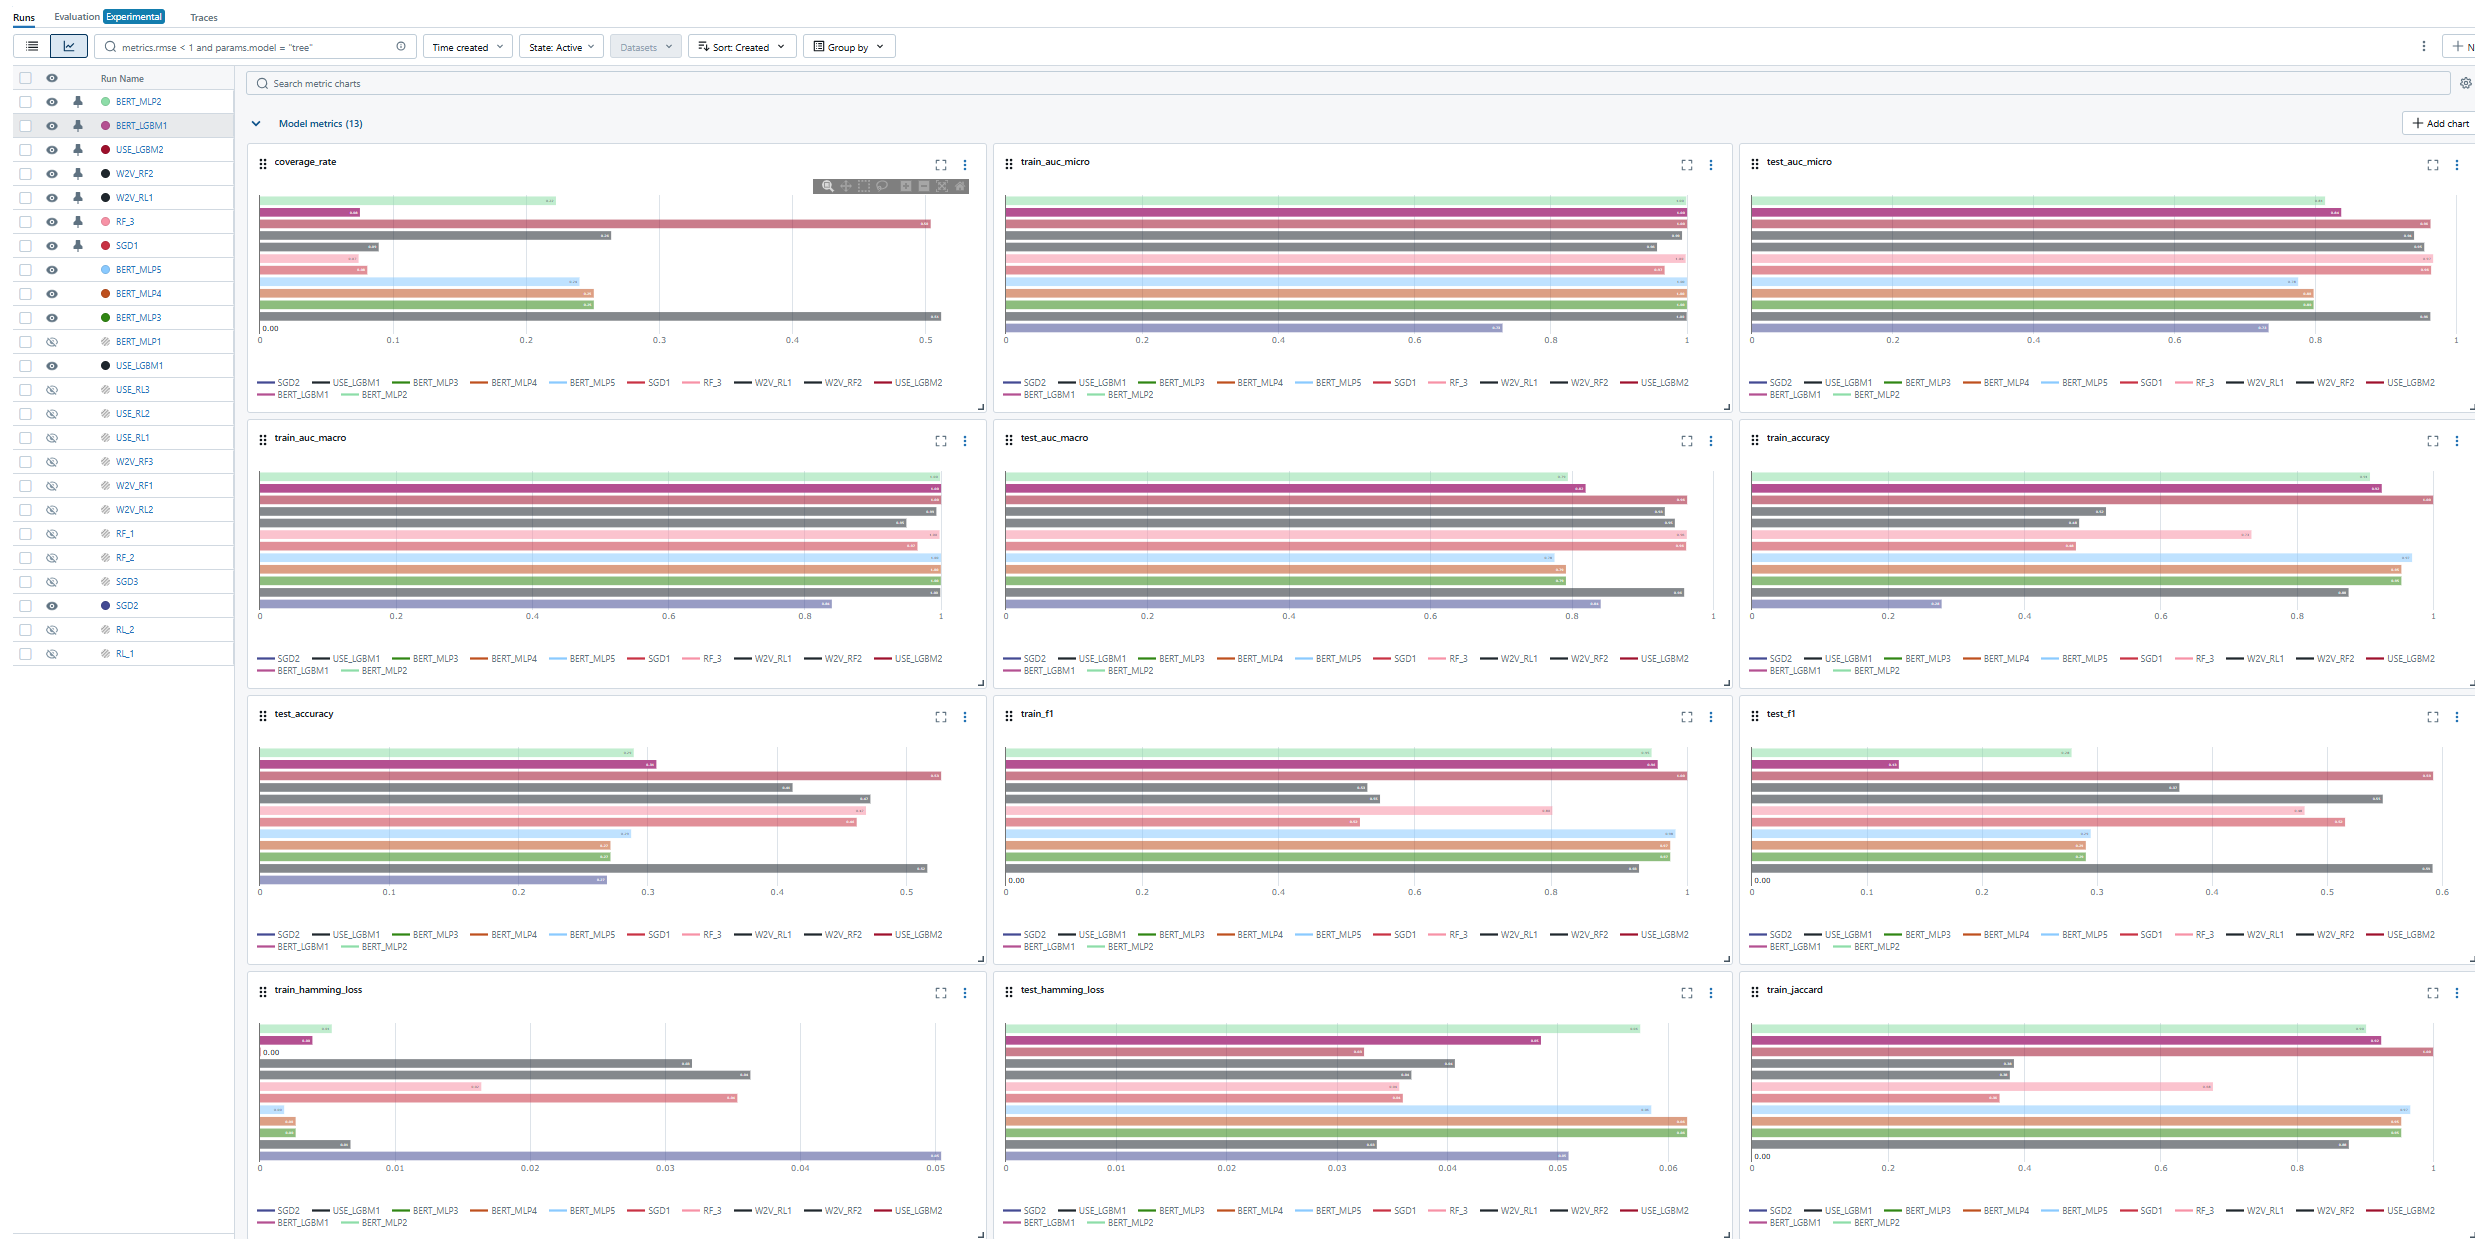

On ira directement sur mlflow pour lire les résultats mais le choix est déjà porté sur la régression logistique.

**Création de l'API**

!pip show protobuf


!pip uninstall protobuf -y


!pip install protobuf==3.20.1


Dans le bash, il conviendra d'appeler l'API<br>
(env5) C:\envs\P5_API>streamlit run app.py

# Spécifie le nom du modèle
model_name = "RL1_registered_model"

# Obtenez les versions et leur statut
client = mlflow.tracking.MlflowClient()
model_versions = client.get_latest_versions(model_name)

# Afficher les informations de chaque version
for version in model_versions:
    print(f"Version: {version.version}, Statut: {version.status}")

FIN